## Welcome on board! 

This is my first notebook upload, or lets say challenge, to Kaggle Competitions. Hope you enjoy!

Before we start, I believe that this notebook will help you to see how a classification problem can be handled from scratch. We will cover some common steps and try to make heuristic comments.

If you feel overwhelmed with python implementations, you can check Python Data Science Handbook by Jake VanderPlas.
Here: https://jakevdp.github.io/PythonDataScienceHandbook/

Let's dive into the challenge. We have a **binary classification problem** for Titanic Survivals and our evaluation metric is **accuracy** as mentioned in the problem summary. Survival percentage is given as **%38** in the training dataset which means we have an imbalanced dataset. My objective is to use four different ML algorithms which are **K-Nearest Neighbor(KNN), Random Forest(RF), Light Gradient Boosting Machine(LGBM), and Extreme Gradient Boosting(XGB)** as baseline models. After selecting the top performer(XGB), Hyperparameter search will be implemented to obtain final predictions for the submission.

We will go through some common steps:<br>
1) [Preparing libraries and data](#1)<br>
2) [Exploratory data analysis(EDA)](#2)<br>
3) [Preprocess the data](#3)<br>
4) [Model selection and hyperparameter search](#4)<br>
5) [Final prediction and export](#5)

# 1) Preparing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocess libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer # to deal with missing values
from sklearn.preprocessing import MinMaxScaler # for scaling
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold # for hyperparameter search

# Models
import lightgbm as lgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

plt.style.use('ggplot') 
color_pal = sns.color_palette()

In [2]:
# Obtain Data
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Notes on investigating the data 
Before EDA part, we should learn the variables and derive some facts from the data. First, let's give an brief introduction of the data by investigating the shape, numerical&categorical variables, missing values, and distribution of the target. Our aim is **to reduce the number of variables without losing information about the target** by looking at their missing percentage and effectiveness on the target (for example "PassengerId" variable may not be related to the target.) 

Lets review:
 * Describing variables
 * Numerical and categorical variables
 * Missing values
 * Distribution of the target variable

In [3]:
# Brief Introduction of Data
print("---------------Describing Numerical Variables---------------")
display(df.describe())
print("---------------Describing Categorical Variables---------------")
display(df.describe(include="object"))
print("---------------Feature Information---------------")
display(df.info())
print("---------------Missing Value Percentage---------------")
print(round(df.isnull().sum()/df.shape[0]*100,1))

---------------Describing Numerical Variables---------------


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


---------------Describing Categorical Variables---------------


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


---------------Feature Information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

---------------Missing Value Percentage---------------
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age            19.9
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.2
dtype: float64


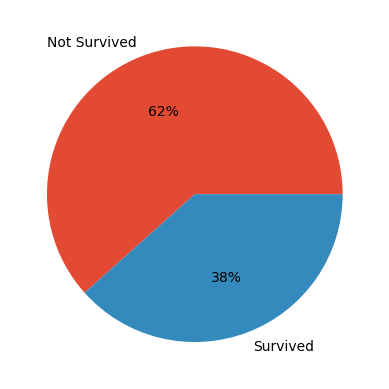

In [4]:
# Pie chart for the survival rate 
plt.pie(x=df["Survived"].value_counts(), labels=df["Survived"].value_counts() \
        .index.map({1:"Survived",0:"Not Survived"}), autopct='%.0f%%')
plt.show()

After a quick investigation on the data, some processes should be performed:
 * Some variables irrelevant to the target should be removed. In that manner, PassengerID, Name and Ticket are not related to both the target and binary classification problem. 
 * Cabin variable has 77% missing values which can not be appropriately filled.
 * We have some variables which can be treated as ordinal and binary variables instead of categorical variables. SibSp, Parch, and Pclass can be treated as ordinal(numerical). Sex can be treated as a binary variable since it has only 2 classes.
 
PassengerId, Name, Cabin, and Ticket variables are removed.

In [5]:
# Preprocess part 1
def initial_preprocess(df):
    df.drop(["PassengerId","Name","Cabin","Ticket"], axis=1, inplace=True) #remove passenger Id, NAME, cabin, ticket
    df["Sex"] = df["Sex"].replace({"female":0, "male":1}).astype("int")
    return df
df = initial_preprocess(df)

# 2) Exploratory Data Analysis (EDA)

In this step, we will discover some trends and facts by visualizing the variables. We will try to answer some questions like which gender is more likely to survive, whether we have outliers in Age or which variables are more related to the sale prices(target).

In [6]:
# Lets group the variables for visualization purposes.
list_categorical = ["Embarked"]
list_numerical = ["Age", "Fare", "Pclass", "Sex", "SibSp", "Parch"]

# For visualization purposes, I also added Sex and Pclass variables into categorical list
list_categorical_viz = ["Embarked","Sex","Pclass"]

### Visualization for Categorical Variables

We will check the distribution and survival rates for each categorical variable.

In [7]:
# Bar plots for categorical variables (relative frequency) vs survival rates

def plot_survive_rates(df,var,hue):
    xtick_order = df[var].value_counts().index.sort_values()

    g = sns.barplot(x=var, y=hue, data=df, saturation=0.5,ci=None, order=xtick_order)
    g.set(ylim=(0, 1))
    
    plt.xlabel(var,fontsize=16)
    plt.ylabel(hue, fontsize=16)
    
    # Remove the graph borders
    for spine in g.spines:
        g.spines[spine].set_visible(False)
  
    # Add rotation to x labels      
    plt.xticks(rotation = 45)

    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches (Patches are Artists with a face color and an edge color.)
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%0.2f' % p.get_height(), 
              fontsize=12, color='darkred', ha='center', va='bottom');


/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1255/2041493757.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=var, y=hue, data=df, saturation=0.5,ci=None, order=xtick_order)
/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1255/2041493757.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=var, y=hue, data=df, saturation=0.5,ci=None, order=xtick_order)
/var/folders/2c/k6r12c3d4jjcdrmrlsr5bn8h0000gn/T/ipykernel_1255/2041493757.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=var, y=hue, data=df, saturation=0.5,ci=None, order=xtick_order)


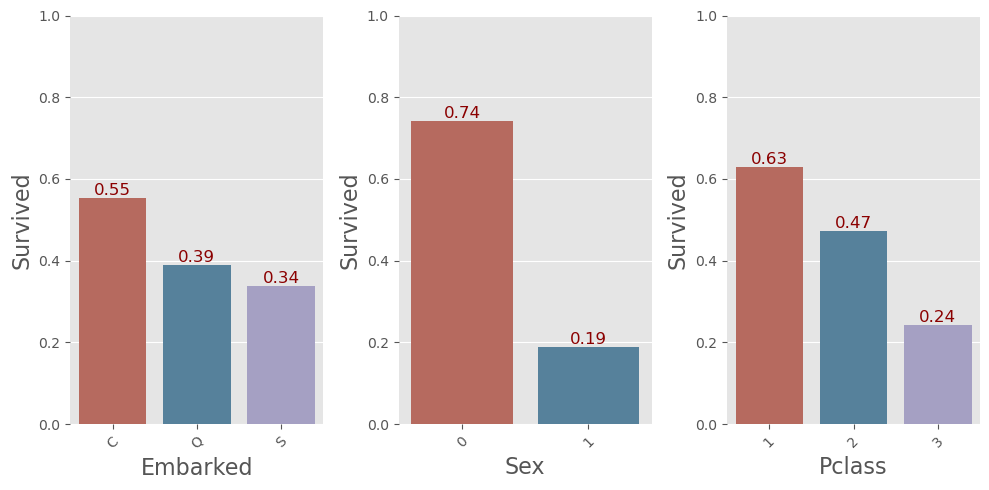

In [8]:
# Plot for each feature
plt.figure(figsize = [10, int(np.ceil(len(list_categorical_viz)/3))*5]) 

i=0
for i in range(len(list_categorical_viz)): 
    plt.subplot(int(np.ceil(len(list_categorical_viz)/3)),3,i+1)
    plot_survive_rates(df,list_categorical_viz[i],"Survived")

plt.tight_layout()  
plt.show()

**Comments:**
* First class passengers have higher survival rates comparing to other classes.
* Female passengers have higher survival rates.
* Passengers from Cherbourg have higher survival rates. 

We have some answers for survival rates. However, we should also see variable pair relations to get more information (bivariate analysis). 

### Visualization for Numerical Variables

Lets perform some analysis to investigate the numerical variables
 * Univariate Analysis by using Boxplots and Histograms
 * Bivariate Analysis by using Pairplot
 * Multivariate Analysis by using Heatmap

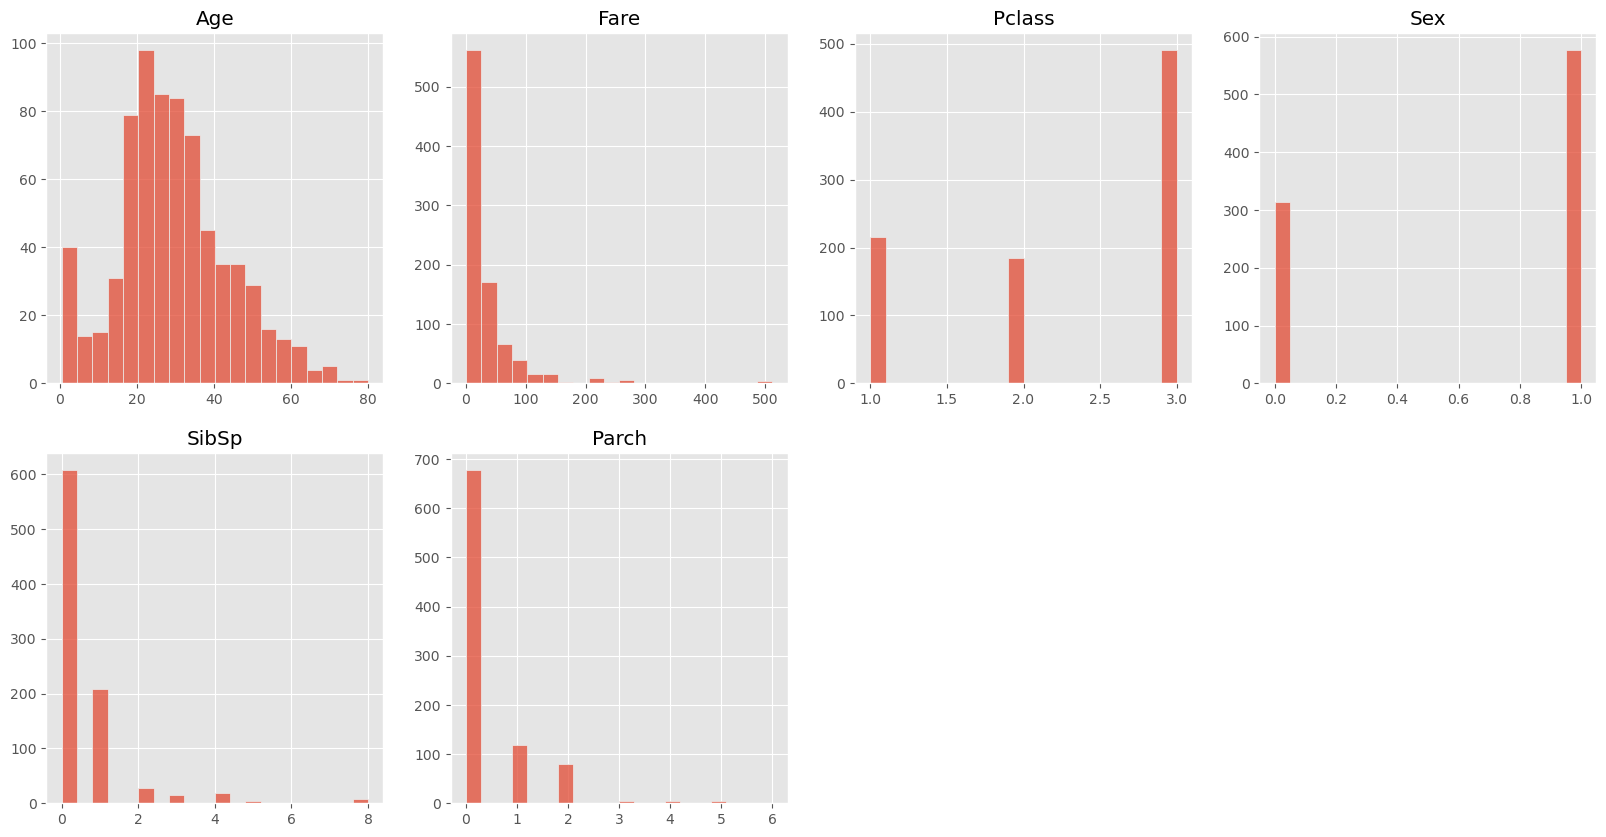

In [9]:
def plot_hist(df,var):
    bw=(df[var].max()-df[var].min())/20
    g = sns.histplot(x = var, data = df, binwidth=bw)
    g.set(xlabel="",ylabel="")
    g.set_title('{}'.format(var))
    
def histViz(df,num_list):
    ncol=4
    plt.figure(figsize = [20, int(np.ceil(len(num_list)/ncol))*5]) 
    plt.tight_layout()    

    for i in range(len(num_list)):
        plt.subplot(int(np.ceil(len(num_list)/ncol)),ncol,i+1)
        plot_hist(df,num_list[i])

    plt.show()
    
histViz(df,list_numerical)

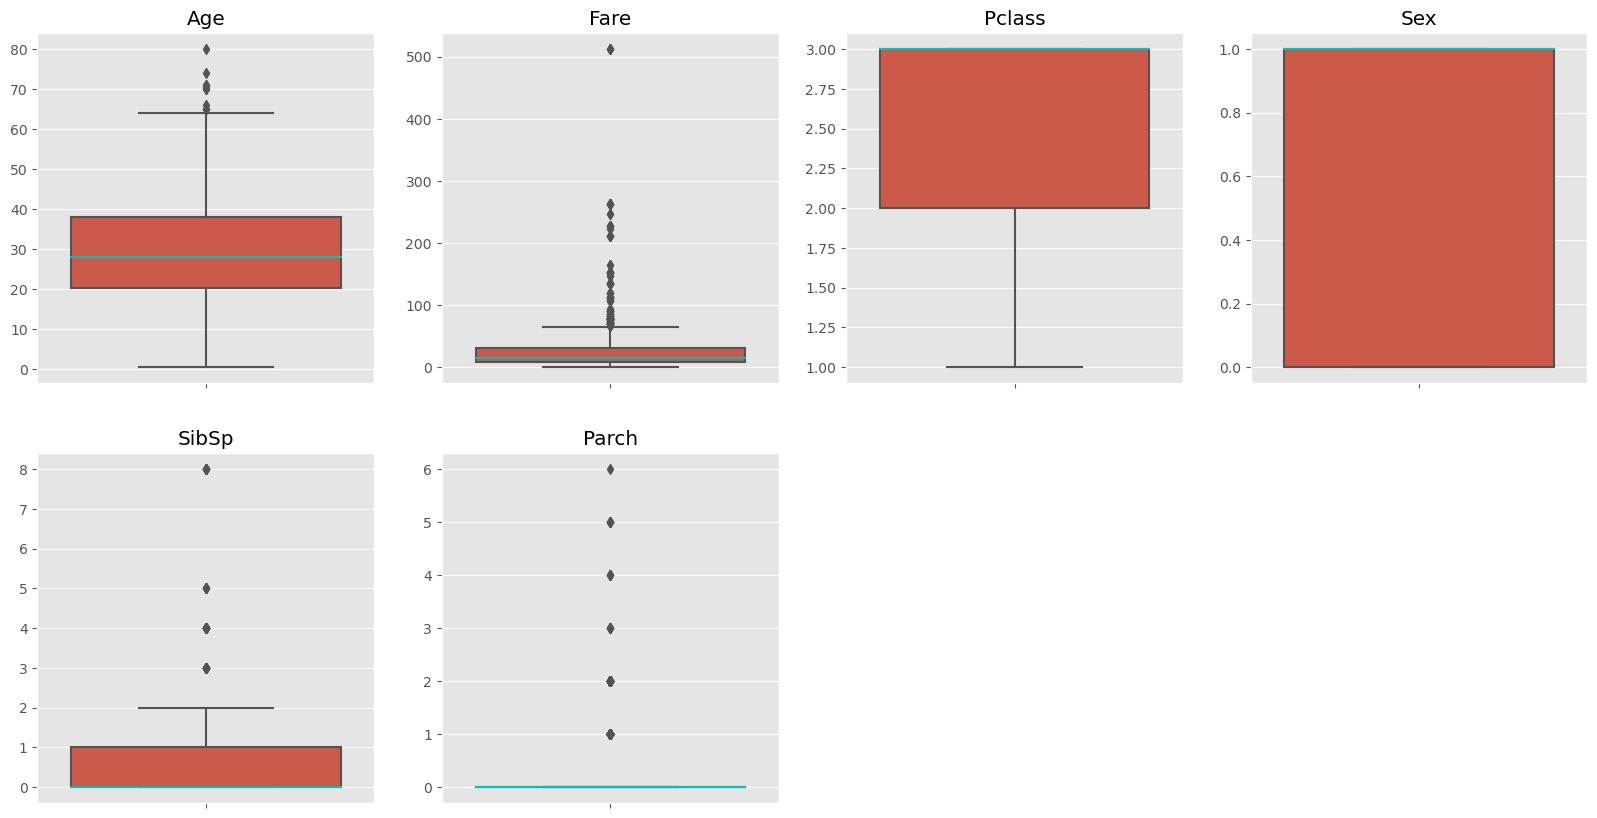

In [10]:
def plot_box(df,var):
    bw=(df[var].max()-df[var].min())/20
    g = sns.boxplot(y = var, data = df, medianprops={'color':'c'})
    g.set(xlabel="",ylabel="")
    g.set_title('{}'.format(var))
    
def BoxViz(df,num_list):
    ncol=4
    plt.figure(figsize = [20, int(np.ceil(len(num_list)/ncol))*5]) 
    plt.tight_layout()    

    for i in range(len(num_list)):
        plt.subplot(int(np.ceil(len(num_list)/ncol)),ncol,i+1)
        plot_box(df,num_list[i])

    plt.show()
    
BoxViz(df,list_numerical)

**Comments:** We can obtain some facts for the numerical variables by comparing their distributions. Some examples are given below.

 * Our variables do not seem to have normal distribution. (May be Age)
 * We have outliers in some variables like Fare. We can also remove outliers but it is not implemented in this notebook.

### Bivariate Analysis - EDA

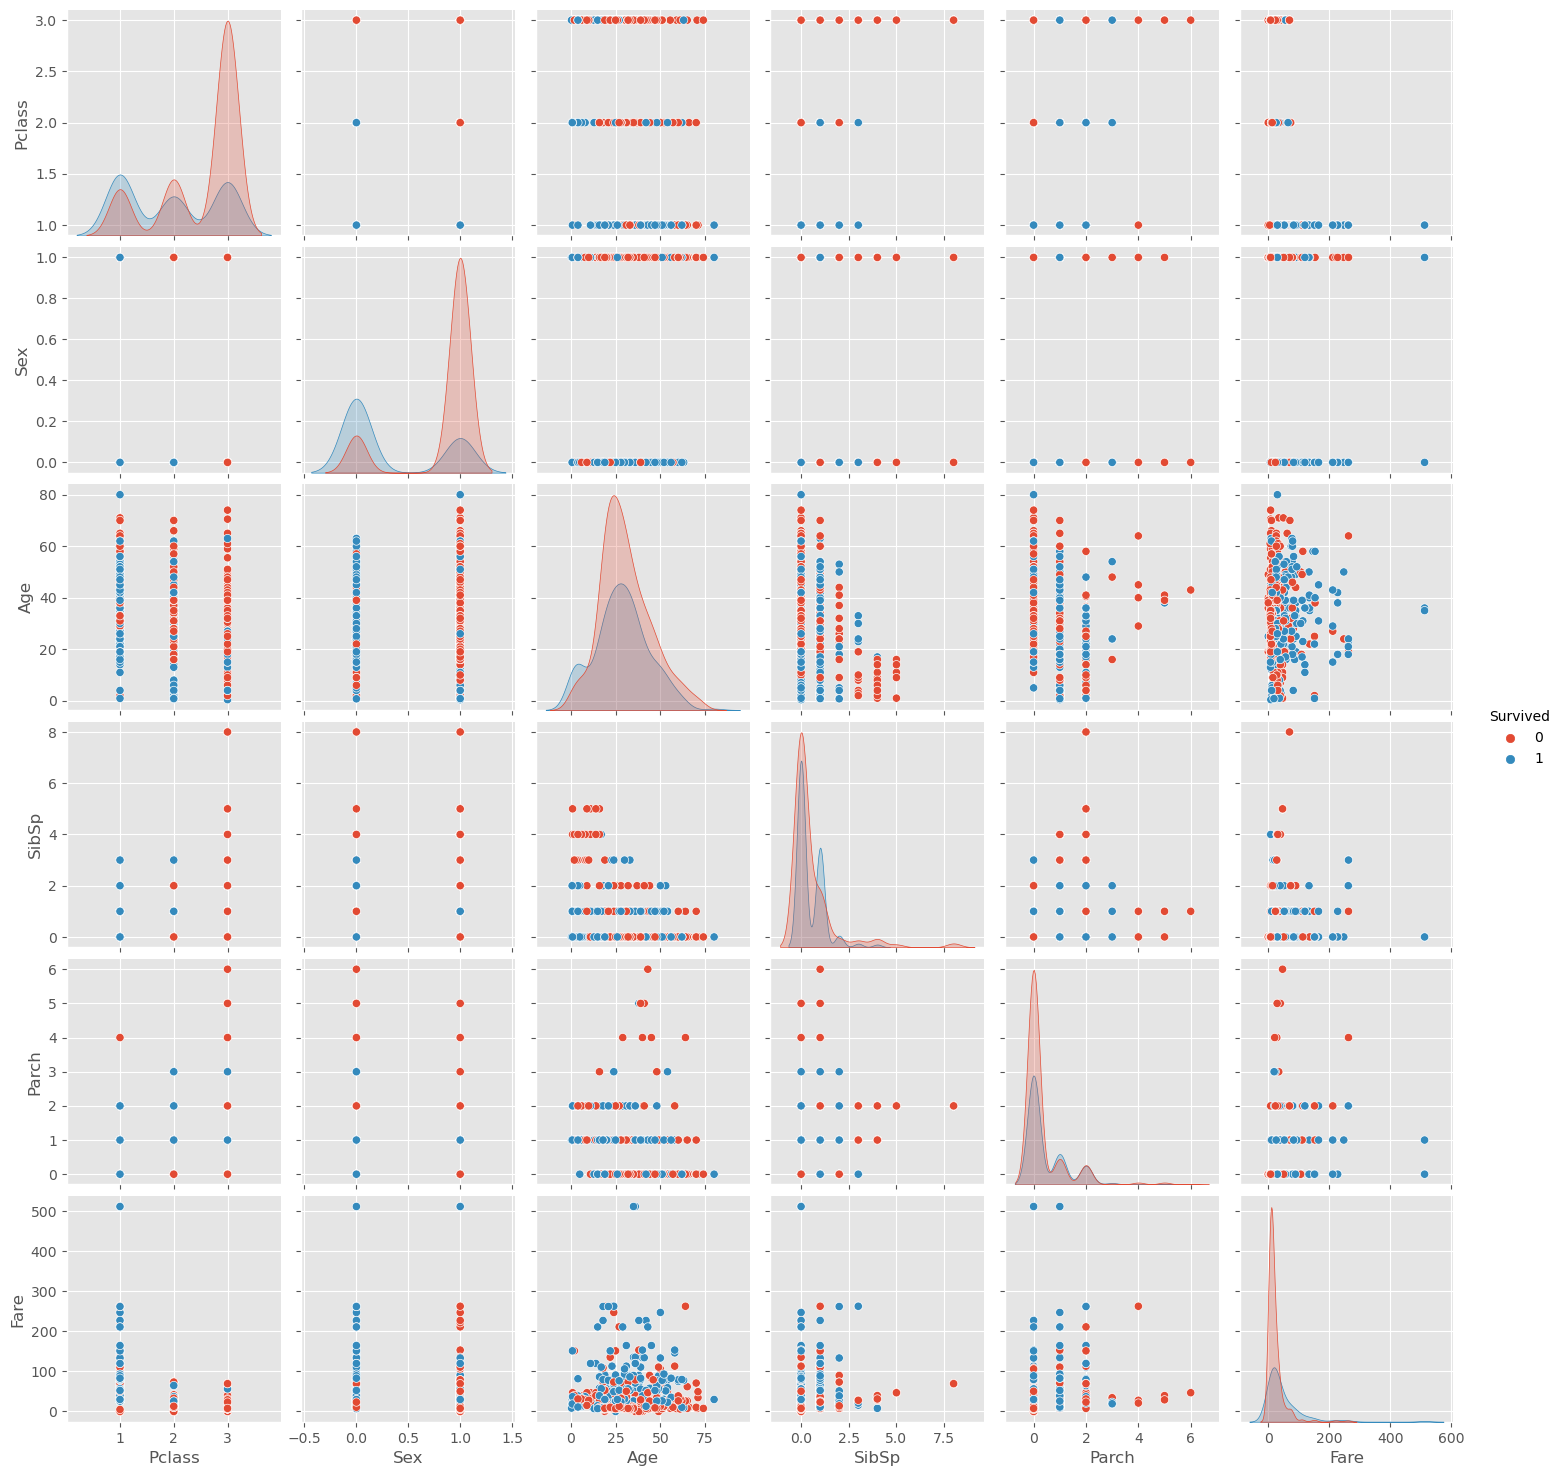

In [11]:
#pairplot
sns.pairplot(df, hue="Survived")
plt.show()

**Comments:**
* Pclass vs. Fare: the first class passengers have higher fares and they seem more likely to survive.
* Age Distribution (age vs. age): it seems younger passengers have higher survival rates.  

Lets see the correlation map for our data.

### Multivariate Analysis - EDA

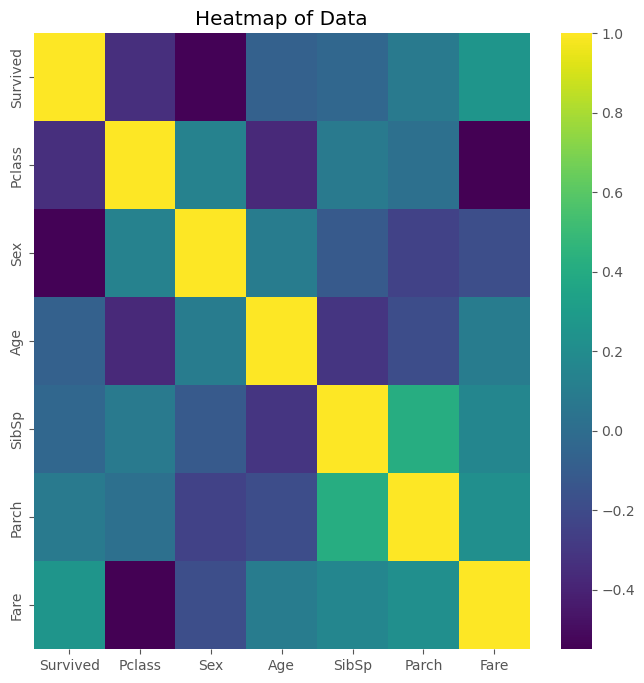

In [12]:
# Correlation map for numerical variables. We have some correlated variables. 
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), cmap="viridis")
plt.title("Heatmap of Data")
plt.show()

In [13]:
# correlations for survival
df.corr()["Survived"].to_frame().T.round(4)*100
#It seems Fare and Pclass are correlated which makes sense!

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,100.0,-33.85,-54.34,-7.72,-3.53,8.16,25.73


**Comments:** Collinearity is an another issue for Machine Learning Algorithms, especially for parametric ones. For example, Pclass is related to the Fare. We could handle the collinearity by using dimensionality reduction methods such as PCA. We will let the model handle. 

We have also listed the most related variables to the target above and they make sense. For example, Pclass is a key factor for the survival rate. 

# 3) PreProcessing

In this section, we will prepare the data for ML algorithms by handling missing values and performing one hot encoding for categorical variables and min-max scaling for numerical variables. 

* **Missing handling:** The most frequent class(mode) for categorical variables and median value for numerical variables will be used.<br>
* **One Hot Encoding:** Since categorical variables can not be directly used in many models, we will use one hot encoding.<br>
* **Scaling:** To reduce the effect of scale of some numerical variables like fare, MinMaxScaler will be used.

We will use ColumnTransformer and Pipeline for the processes, but first let's create our validation datasets.

**Important Note:** Since the target is imbalanced, we should use stratification in both train_test split part and cross-validation(CV) in hyperparameter search part.

In [14]:
# Train Test Datasets
X = df.drop("Survived", axis=1)
y = df["Survived"]

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.20, stratify = y, random_state=1234)
print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')
print(f'Xval shape: {Xval.shape}, yval shape: {yval.shape}')

Xtrain shape: (712, 7), ytrain shape: (712,)
Xval shape: (179, 7), yval shape: (179,)


In [15]:
categorical_var = Xtrain.select_dtypes(include="object").columns.to_list()
cat_index_list = Xtrain.columns.to_frame(index=False,name="variables").query('variables in @categorical_var').index.to_list()

# Transformers for categorical values
cat_pipe = Pipeline([('imputer_frequent', SimpleImputer(strategy="most_frequent")),
                     ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False))])

# Transformers for numerical values
num_pipe = Pipeline([('imputer_median', SimpleImputer(strategy="median")), 
                     ('MinMax_scaling', MinMaxScaler())
                     ])

ct = ColumnTransformer([('cat_pipe',cat_pipe,cat_index_list)], 
                       remainder=num_pipe)#num_pipe

Xtrain = pd.DataFrame(ct.fit_transform(Xtrain)) 
Xval = pd.DataFrame(ct.transform(Xval))

In [16]:
print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')
print(f'Xval shape: {Xval.shape}, yval shape: {yval.shape} \n')
print("Since OneHotEnconder is used, the number of variables is increased.")

Xtrain shape: (712, 9), ytrain shape: (712,)
Xval shape: (179, 9), yval shape: (179,) 

Since OneHotEnconder is used, the number of variables is increased.


# 4) Model Selection and Hyperparameter Search

After the Preprocessing Section, our dataset is ready for modeling! Let's calculate the baseline scores for our models.

In [17]:
# For baseline accuracies
def evaluationMetrics(clf,Xtrain,Xval,ytrain,yval,refit=True):
    
    dict_output= {}
    
    if refit:
        clf.fit(Xtrain,ytrain)
    ytrainPred=clf.predict(Xtrain)
    ytestPred=clf.predict(Xval)
    
    #train lists
    # we can also add f1 score or ROC AUC as metrics
    dict_output["clf_name"]=type(clf).__name__
    dict_output["train_acc"]=accuracy_score(ytrain,ytrainPred)
    #test lists
    dict_output["val_acc"]=accuracy_score(yval,ytestPred)

    return dict_output

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

,clf_name,train_acc,val_acc
0,KNeighborsClassifier,0.867978,0.798883
1,RandomForestClassifier,0.981742,0.782123
2,LGBMClassifier,0.941011,0.810056
3,XGBClassifier,0.971910,0.815642


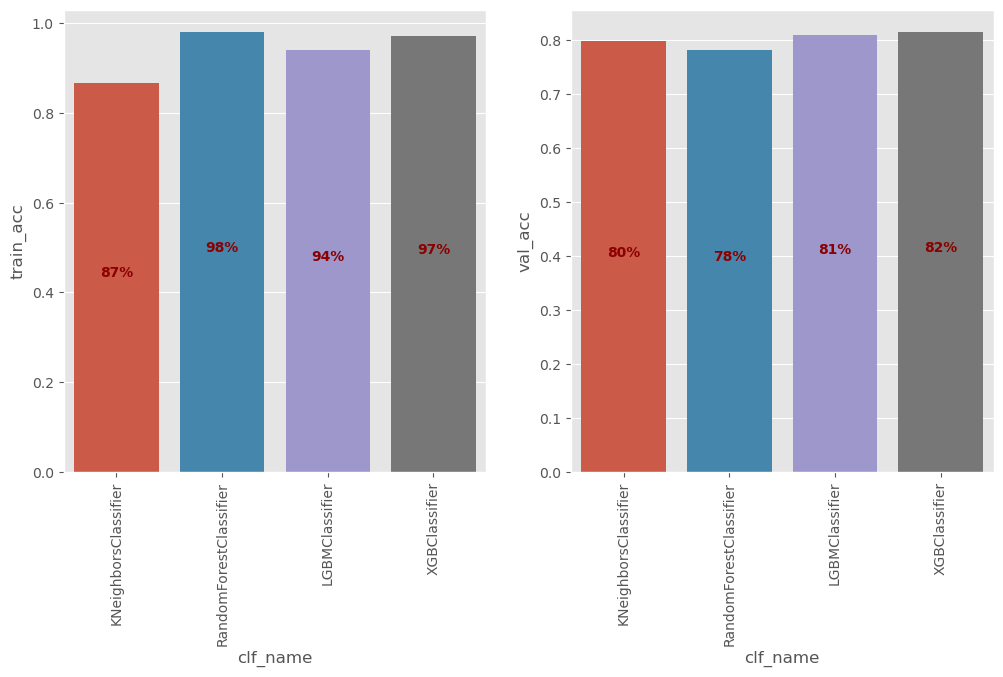

In [18]:
# Classifiers
clf_list=[KNeighborsClassifier(n_neighbors=5),
          RandomForestClassifier(n_estimators = 200),
          LGBMClassifier(objective="binary"),# since we have a binary classification problem
          XGBClassifier(objective="binary:logistic") # since we have a binary classification problem
          ]

for i in range(len(clf_list)):
    if i == 0:
        df_eval=pd.DataFrame(evaluationMetrics(clf_list[i],Xtrain,Xval,ytrain,yval),index=[0])
    else:
        df_eval=df_eval.append(evaluationMetrics(clf_list[i],Xtrain,Xval,ytrain,yval), ignore_index=True)

display(df_eval)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True)
g = sns.barplot(data=df_eval, x='clf_name', y='train_acc', ax=ax1)
for p in g.patches:
  percentage = '{:.0f}%'.format(100*p.get_height())
  x = p.get_x() + p.get_width()/2
  y = p.get_height() *0.5
  g.annotate(percentage, (x, y),ha='center', size='medium', color='darkred', weight='semibold')

g = sns.barplot(data=df_eval, x='clf_name', y='val_acc', ax=ax2)
for p in g.patches:
  percentage = '{:.0f}%'.format(100*p.get_height())
  x = p.get_x() + p.get_width()/2
  y = p.get_height() *0.5
  g.annotate(percentage, (x, y),ha='center', size='medium', color='darkred', weight='semibold')

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)

plt.show()

As baseline scores, **XGB** outperformed the others for **both training and test results**. Let's try to search hyperparameters for XGB (the results may differ in each run).

Before Hyperparameter search, I would like to mention some methods to increase model performances for imbalanced datasets. 
 * The first one is resampling methods which you can generate synthetic minorty class to balance the data (as oversampling) or select some data from majority class to balance the data (as undersampling). There are many approaches for both oversampling and undersampling (for further: please check imblearn library). 
 * The second one is class weight. Most models have their own class weight parameter to deal with imbalanced datasets. You can use sklearn.utils to calculate class weights or you can calculate by your own. In this notebook, I leave the following cell for class weight calculation, but I will not use in the model (I tried and got worse results).

In [ ]:
# for illustration of the class weight calculation.
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(ytrain), y=ytrain)

For the hyperparameter search of XGB, number of estimators, min child weight, max depth, and subsample are used with RandomizedSearchCV and the final result is shown below. Randomized Search is used instead of Grid Search due to the computation power limitations.

For further information about XGB: https://xgboost.readthedocs.io/en/stable/parameter.html

In [19]:
# Tuning XGBOOST 
cv = StratifiedKFold(n_splits = 5, shuffle = True)

XGBParams = {"n_estimators" : [250,500,1000,2000],
            "learning_rate": [0.01, 0.1, 0.3, 0.5, 1], #default=0.3   
            "min_child_weight": range(1,12,2), #default=1  
            "max_depth": range(6,13,2), #default=6
            "subsample": [0.2, 0.5, 0.8, 1]} #default=1

rscv_xgb = RandomizedSearchCV(XGBClassifier(objective="binary:logistic"), XGBParams,
                          cv = cv, return_train_score = True, n_iter=10) #you can increase for better results

rscv_xgb.fit(Xtrain, ytrain)
yhat2 = rscv_xgb.predict(Xval)
yhat_train2 = rscv_xgb.predict(Xtrain)

print("Best n_estimators:", rscv_xgb.best_estimator_.n_estimators)
print("Best learning_rate:", rscv_xgb.best_estimator_.learning_rate)
print("Best min_child_weight:", rscv_xgb.best_estimator_.min_child_weight)
print("Best max_depth:", rscv_xgb.best_estimator_.max_depth)
print("Best subsample:", rscv_xgb.best_estimator_.subsample)
print(f"Train Accuracy: {round(accuracy_score(ytrain, yhat_train2),4)}, Test Accuracy: {round(accuracy_score(yval, yhat2),4)}")

Best n_estimators: 500
Best learning_rate: 0.1
Best min_child_weight: 7
Best max_depth: 6
Best subsample: 0.8
Train Accuracy: 0.9129, Test Accuracy: 0.7933


After Hyperparameter search, we increased the test accuracy to **83%** by **sacrificing training accuracy around 10%**. We could tune more parameter to increase test accuracy, but it is enough for this brief notebook.

Note: Do not forget that it is a random search. The results can vary depending on random states!

# 5) Final Prediction and Export

Let's preprocess the test dataset by using our preprocess function and ColumnTransformer, then submit it.

In [20]:
# preprocess for test 
df_test = initial_preprocess(df_test)
df_test = pd.DataFrame(ct.transform(df_test))

# Test prediction with our model.
ytest_hat = rscv_xgb.predict(df_test)

In [22]:
# Exporting the submission file
df_tmp = pd.read_csv("test.csv")
df_tmp2 = df_tmp[["PassengerId"]]
df_final = df_tmp2.merge(pd.DataFrame(ytest_hat), left_index=True, right_index=True)
df_final.rename(columns={0:"Survived"}).set_index("PassengerId").head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


If you found this notebook helpful, some upvotes would be very much appreciated! :) 

You can also check my second notebook for a regression problem in Kaggle: https://www.kaggle.com/code/egeerkmen/catboost-and-xgb-with-detailed-eda